<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/8_Mixture_Models_and_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


# Mixture models
One way to create more complex probability models is to take a convex combination of simple distributions. This is called a **mixture model**.

It has the following form, 
\begin{align}
p(\m{x}|\mm\theta) = \sum_{k=1}^K\pi_k p_k(\m x)
\end{align}
where $p_k$ is the $k$-th mixture component and $\pi_k$ are mixture weight with $0\le \pi_k\le 1$ and $\sum_{k=1}^K \pi_k=1$. 

The model is expressed by the following generative process. 

-  Generate the discrete **latent variable** $z\in \{1, \dots, K\}$ from the multinomial distribution $\pi =(\pi_1, \dots, \pi_K)$ with 
$$p(z=k|\mm\theta) =\pi_k.$$

- Given the latent variable $z=k$, generate a point $\mathbf{x}$ from the conditional distribution $p(\m{x}|z=k, \mm\theta)$.

If we margalize the latent variable $z$, we will recover the previous distribution form: 
\begin{align}
p(\m{x}|\mm\theta)  = \sum_{k=1}^K p(z=k|\mm\theta) p(\m{x}|z=k,\mm\theta)=\sum_{k=1}^K \pi_k p(\m{x}|\mm\theta_k)
\end{align}


We can create different kinds of mixture model by varying the conditional distribution $p(\m{x}|\mm\theta_k)$. 

**Goal:** Given the data $\{\m{x}^{(i)}\}_{i=1}^N$, we would like to infer the parameters $\mm\theta$ and recover the latent variable $z^{(i)}$.

In fact, this is a **clustering** in the unsupervised learning. 

## Gaussian mixture models (GMM)
If we use the Gaussian distribution for the conditional distribution $p(\m{x}|\mm\theta_k)= \c{N}(\m{x}|\mm\mu_k, \mm\Sigma_k)$. 

Note if we let the number of mixture components grow sufficiently large, a GMM can approximate any smooth distribution over $\mb{R}^D$. 


- The ratio of number of points in the k clusters is
$\pi_1: \pi_2 : \dots:\pi_K$. 

- Points from each cluster are distributed roughly over a ellipsoid centered
at $\mm\mu_1, \dots, \mm\mu_K$. whereas the density of points is determined by the corresponding covariance matrix. 

<img src="https://github.com/yexf308/MAT592/blob/main/image/GMM3.png?raw=true" width="400" />

### Maximum likelihood estimation
Denote model parameters by $\mm\theta:= \{\pi_c, \mu_c, \Sigma_c\}_{c=1}^K$. The log-likelihood is 
\begin{align}
&\ell(\mm\theta) = \sum_{i=1}^N\log p(\m{x}^{(i)}|\mm\theta)  \\
&\hat{\mm\theta} =  \arg\max_{\mm\theta} \ell(\mm\theta)
\end{align}

Unlike in Gaussian model, the MLE problem of Gaussian mixture has **NO**
analytic solution. Also it is not easy to use gradient method because of $\Sigma$. 

In [ ]:

mu1 = np.array([0.22, 0.45])
mu2 = np.array([0.5, 0.5])
mu3 = np.array([0.77, 0.55])
Mu = [mu1, mu2, mu3]

Sigma1 = np.array([[0.011, -0.01], [-0.01, 0.018]])
Sigma2 = np.array([[0.018, 0.01], [0.01, 0.011]])
Sigma3 = Sigma1
Sigma = [Sigma1, Sigma2, Sigma3]
Pi = np.array([0.5, 0.3, 0.2])


In [ ]:
def sigmaEllipse2D(mu, sigma, level=3, npoints=128):
    phi = np.linspace(0, 2 * np.pi, npoints)
    x = np.cos(phi) * level
    y = np.sin(phi) * level
    z = np.zeros([npoints,2])
    z[:,0]=x
    z[:,1]=y
    xy = mu + z.dot(np.linalg.cholesky(sigma))
    return xy

In [ ]:
def plot_sigma_levels(mu, sigma):
    level_span = [0.25, 0.5, 0.75, 1, 1.25, 1.5]
    for level in level_span:
      xy = sigmaEllipse2D(mu, sigma, level)
      plt.plot(xy[:,0], xy[:,1],'b')

    plt.plot(mu[0], mu[1], "ro")

In [ ]:
def plot_sigma_vector(Mu, Sigma):
    n = len(Mu)
    plt.figure(figsize=(8, 6))
    for i in range(n):
        plot_sigma_levels(Mu[i], Sigma[i])
    plt.tight_layout()
    plt.show()

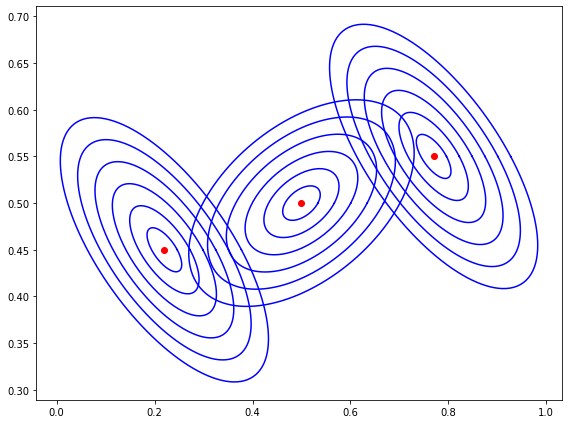

In [ ]:
plot_sigma_vector(Mu, Sigma)
# Contours of Gaussian PDF for k=1,2,3

In [ ]:
import plotly.graph_objects as go
from scipy.stats import multivariate_normal 

x = np.arange(0, 1, 0.01)
y = np.arange(-0.5, 1.2, 0.01)

X, Y = np.meshgrid(x, y)
Pos = np.dstack((X, Y))
Z = 0

for i in range(len(Mu)):
  Z = Z + Pi[i] * multivariate_normal(Mu[i], Sigma[i]).pdf(Pos)

fig = plt.figure(figsize=(8, 6))
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True)) 
# surface plot 

<Figure size 576x432 with 0 Axes>

## Expectation-Maximization(EM) algorithm
Log-likelihood for any distribution with the latent variable. If $\m{x}^{(i)}$ are sampled in i.i.d manner. 

\begin{align}
\ell(\mm\theta) = -\sum_{i=1}^N\log p(\m{x}^{(i)}|\mm\theta)=\sum_{i=1}^N\log\sum_{k=1}^K p(\m{x}^{(i)}, z^{(i)}=k|\mm\theta) 
\end{align}

where $\m{x}$ are observed dataset and $z$ are discrete hidden variables. 


### Background
The basic idea behind EM algorithm is alternate between estimating the hidden variables during the **E step** (expectation step), and then using the fully observed data to compute the MLE during the **M step** (maximization step). Of course we need to iterate this process since the expected values depend on the parameters, but the parameters depend on the expected values. 


- Consider a set of arbitary distribution $q(z^{(i)})$ over each hidden variable $z^{(i)}$. The observed data log likelihood can written as follows: 
$$ \ell(\mm\theta)=\sum_{i=1}^N\log\left(\sum_{k=1}^K q(z^{(i)}=k) \frac{p(\mathbf{x}^{(i)}, z^{(i)}=k|\mm\theta)}{q(z^{(i)}=k)}\right) $$

- Using Jensen's inequality, $\phi(\sum_i a_ix_i)\ge  \sum_i a_i \phi(x_i)$ for any concave function $\phi$ and $\sum_i a_i=1$.
\begin{align}
\ell(\theta)&\ge \sum_{i=1}^N \sum_{k=1}^K q(z^{(i)}=k) \log\left( \frac{p(\mathbf{x}^{(i)}, z^{(i)}=k|\mm\theta)}{q(z^{(i)}=k)}\right) \\
&\triangleq \sum_{i=1}^N \c{E}[\mm\theta,z^{(i)}|\m{x}^{(i)}] = \c{E}[\mm\theta, \{z^{(i)}\}_{i=1}^N |\{\m{x}^{(i)}\}_{i=1}^N ] 
\end{align}
 $\c{E}[\mm\theta, \{z^{(i)}\}_{i=1}^N |\{\m{x}^{(i)}\}_{i=1}^N ]$ is called the **evidence lower bound** or **ELBO**, since it is a lower bound on the log marginal likelihood $\log p(\{\m{x}^{(i)}\}_{i=1}^N|\mm\theta)$ 

- 
We see that the lower bound is a sum of $N$ terms, each of which has the following form
\begin{align}
\mathcal{E}[\mm\theta,z^{(i)}|\mathbf{x}^{(i)}] &= \sum_{k=1}^K q(z^{(i)}=k) \log\left( \frac{p(\mathbf{x}^{(i)}, z^{(i)}=k|\mm\theta)}{q(z^{(i)}=k)}\right) \\
&=\sum_{c=1}^K q(z^{(i)}=k) \log\left( \frac{p(z^{(i)}=k| \mathbf{x}^{(i)},\mm\theta)p(\mathbf{x}^{(i)}|\mm\theta)}{q(z^{(i)}=k)}\right)\\
&= \sum_{k=1}^K q(z^{(i)}=k) \log\left( \frac{p(z^{(i)}=k| \mathbf{x}^{(i)},\mm\theta)}{q(z^{(i)}=k)}\right) + \sum_{c=1}^K q(z^{(i)}=k)  \log p(\m{x}^{(i)}|\mm\theta) \\
&=-\text{KL}(q(z^{(i)})||p(z^{(i)}| \m{x}^{(i)},\mm\theta)) + \log p(\m{x}^{(i)}|\mm\theta) 
\end{align}
where $\text{KL}(q||p)=\sum_z q(z)\log\left(\frac{q(z)}{p(z)}\right)$ is the Kullback-Leibler divergence (or KL divergence for short)
between probability distributions $q$ and $p$. 
  
  - The key
property we need here is that $\text{KL}(q||p)\ge 0 $ and $\text{KL}(q||p)=0$ iff $q=p$. 

  - We can maximize the
lower bound $\mathcal{E}[\mm\theta, \{z^{(i)}\}_{i=1}^N |\{\mathbf{x}^{(i)}\}_{i=1}^N ]$ with respect to $\{z^{(i)}\}$ by setting each one to $q^*(z^{(i)})=p(z^{(i)}| \mathbf{x}^{(i)},\mm\theta)$. This ensures the ELBO is a **tight lower bound**. 
$$ \arg\max_{\{z^{(i)}\}_{i=1}^N }\mathcal{E}[\mm\theta, \{z^{(i)}\}_{i=1}^N |\{\mathbf{x}^{(i)}\}_{i=1}^N ]=\sum_{i=1}^N\log p(\mathbf{x}^{(i)}|\mm\theta)=\log \ell(\mm\theta)$$ 


### Construct the EM algorithm
At each the $t$-iteration with $\theta^t$, EM algorithm constructs an **surrogate function**,
$$ \boxed{q(\color{blue}{\mm\theta}; \color{red}{\mm\theta^t}) = \sum_{i=1}^N \sum_{k=1}^K \underbrace{p(z^{(i)}=k|\mathbf{x}^{(i)},\color{red}{\mm\theta^t})}_{q(z^{(i)})}\log \frac{p(\mathbf{x}^{(i)},z^{(i)}=k|\color{blue}{\mm\theta})}{p(z^{(i)}=k|\mathbf{x}^{(i)},\color{red}{\mm\theta^t})}}$$ 
which is a lower envelope of Log-likelihood $\ell(\mm\theta)$, i.e, 
$$\ell(\mm\theta) \ge q(\color{blue}{\mm\theta}; \color{red}{\mm\theta^t}), \forall \mm\theta $$
with the equality holds at $\mm\theta^t=\mm\theta$.

- The EM algorithm iterates for $t=0,1,\dots$ to update $\mm\theta$:
$$\color{red}{\mm\theta_{t+1}} = \arg\max_{\mm\theta}q(\color{blue}{\mm\theta}; \color{red}{\mm\theta^t}) $$

- EM algorithm is ascent for maximization:
$$ \ell(\mm\theta^{t+1})\ge q(\mm\theta^{t+1}; \mm\theta^t)\ge q(\mm\theta^{t};\mm\theta^t)=\ell(\mm\theta^t)$$

- In general, global maximum is not guaranteed because the problem is
non-convex.

<img src="https://github.com/yexf308/MAT592/blob/main/image/EM.png?raw=true" width="500" />


### EM algorithm in GMM

- **E(xpecation) step.** 
Evaluate the posterior probability $ \phi_k^{(i), t} = p(z^{(i)}| \m{x}^{(i)},\mm\theta^t)$ using the current parameters $\mm\theta^t =\{\pi_k^t, \mu_k^t, \Sigma_k^t\}_{k=1}^K$:

 \begin{align}
 \phi_k^{(i), t}\triangleq p(z^{(i)}=k| \mathbf{x}^{(i)},\color{red}{\mm\theta^t}) &= \frac{p( \m{x}^{(i)}|z^{(i)}=k, \mm\theta^t)p(z^{(i)}=k| \color{red}{\mm\theta^t})}{p(\m{x}^{(i)}|\color{red}{\mm\theta^t})}  \qquad \text{By Bayes rule} \\
&= \frac{\pi_k^t p(\m{x}^{(i)} | \mm\mu_k^t, \mm\Sigma_k^t)}{\sum_{j=1}^K \pi_j^t p(\m{x}^{(i)} | \mm\mu_j^t, \mm\Sigma_j^t) }, \qquad \forall 1\le i\le N, 1\le k\le K.
 \end{align}
 Where 
 $$ p(\m{x}^{(i)} | \mm\mu_k^t, \mm\Sigma_k^t) = \frac{1}{\sqrt{(2\pi)^d|\mm\Sigma_k|}}\exp\left(-\frac{1}{2}(\m{x}^{(i)}-\mm\mu_k)^\top \mm\Sigma_k^{-1}(\m{x}^{(i)}-\mm\mu_k)\right), \qquad 1\le k\le K$$
 is the PDF for the $k$-th Gaussian distribution of the mixture. 

 **E step gives the clustering/latent variable:**

    - $\phi_k^{(i)}= p(z^{(i)}=k| \m{x}^{(i)},\mm\theta)$ is the posterior probability: the probability that observation $\mm{x}^{(i)}$ comes from the cluster $k$, given the model parameter $\mm\theta$. 

    - $\mm\phi^{(i)} = (\phi_1^{(i)}, \phi_2^{(i)}, \dots, \phi_K^{(i)})$ is the probability vector for $\mathbf{x}^{(i)}$ belonging to each cluster. 

    - Having learned model parameters of Gaussian mixture, we cluster $\ma{x}^{(i)}$ by checking the highest entry in the posterior probability vector 
$$ z^{(i)} = \arg\max_{1\le k\le K} \phi_k^{(i)}.$$



- **M(aximization) step.**
Update parameters by solving
$$\color{red}{\mm\theta^{t+1}}=\arg\max_{\mm\theta} q(\color{blue} \theta, \color{red}{\theta^{t}}) = \arg\max_{\theta}\sum_{i=1}^N \sum_{k=1}^K \phi_{k}^{(i),t} \log \left(\frac{p(\mathbf{x}^{(i)}, z^{(i)}=k|\color{blue}{\mm\theta})}{\phi_{k}^{(i),t} }\right)$$
using the computed posterior probabilities $\phi_{k}^{(i),t}$ from E step. 

  We can switch the order of sum and find out we only need to maximize for each individual $c$.

 Equvilently, 
  \begin{align}
  \pi_k^{t+1}, \mm\mu_k^{t+1}, \mm\Sigma_k^{t+1} &= \arg\max_{\pi_k, \mm\mu_k, \mm\Sigma_k}\sum_{i=1}^N \phi_{k}^{(i),t} \log p(\mathbf{x}^{(i)}, z^{(i)}=k|\{\pi_k, \mm\mu_k, \mm\Sigma_k\})\\
  &= \arg\max_{\pi_k, \mm\mu_k, \mm\Sigma_k} \sum_{i=1}^N  \phi_{k}^{(i),t} \log\left[ \pi_k p(\mathbf{x}^{(i)} |\mm\mu_k, \mm\Sigma_k)\right] \\
  & = \arg\max_{ \mm\mu_k, \mm\Sigma_k} \sum_{i=1}^N \phi_{k}^{(i),t} \log p(\mathbf{x}^{(i)} |\mm\mu_k, \mm\Sigma_k) + \arg\max_{ \pi_k} \sum_{i=1}^N \phi_{k}^{(i),t} \log \pi_k
  \end{align}
  Note that we have constraints $\pi_c\ge 0$ and $\sum_{c=1}^K \pi_c =1$.

 This optimization has analytical solution! Do it yourself.
 \begin{align}
& \pi_k^{t+1}=\frac{\sum_{i=1}^N \phi_{k}^{(i),t}}{\sum_{k=1}^K\sum_{i=1}^N \phi_{k}^{(i),t}}=\frac{1}{N}\sum_{i=1}^N \phi_{k}^{(i),t}, \\
& \mm\mu_k^{t+1} = \frac{\sum_{i=1}^N \phi_{k}^{(i),t}  \mathbf{x}^{(i)}}{\sum_{i=1}^N \phi_{k}^{(i),t}} , \\
& \mm\Sigma_k^{t+1} = \frac{\sum_{i=1}^N \phi_{k}^{(i),t}  \left[\mathbf{x}^{(i)}-\mu_k^{t+1}\right]\left[\mathbf{x}^{(i)}-\mu_k^{t+1}\right]^T}{\sum_{i=1}^N \phi_{k}^{(i),t}}.
\end{align}






<Figure size 432x288 with 0 Axes>

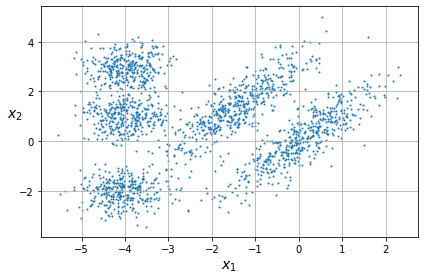

In [ ]:
from sklearn.datasets import make_blobs

def plot_clusters(X, y=None, Mu_array=0):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    if sum(Mu_array) != 0:
        plt.scatter(Mu_array[:,0],Mu_array[:,1],marker="x", color="black", linewidth=2)
        
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.grid()
    plt.tight_layout()  
    plt.show()     


if 0:
    blob_centers = np.array(
        [[ 0.2,  2.3],
         [-1.5 ,  2.3],
         [-2.8,  1.8],
         [-2.8,  2.8],
         [-2.8,  1.3]])
    blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
    X, y = make_blobs(n_samples=2000, centers=blob_centers,
                      cluster_std=blob_std, random_state=7)

if 1:
    # two off-diagonal blobs
    X1, _ = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
    X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
    # three spherical blobs
    blob_centers = np.array(
        [[ -4,  1],
         [-4 ,  3],
         [-4,  -2]])
    s = 0.5
    blob_std = np.array([s, s, s])
    X2, _ = make_blobs(n_samples=1000, centers=blob_centers,
                      cluster_std=blob_std, random_state=7)
    
    X = np.r_[X1, X2]
    K = 5
    
figure()
plot_clusters(X)


In [ ]:
 #@title K-means++ to setup initial conditions
def euclidean_distance(x1, x2):
    return sqrt(sum((x1 - x2) ** 2))
    
# initialization for Kmeans++ algorithm
def initialize(X, K):
    
    ## Step 1: initialize the centroids list and add
    ## a randomly selected data point to the list
    n_samples, n_features = X.shape
    random_sample_idxs = random.choice(n_samples, 1, replace=False)
    centroids = X[random_sample_idxs,:]

    ## compute remaining K - 1 centroids
    for c_id in range(K - 1):
        ## Step 2: initialize a list to store distances of data
        ## points from nearest centroid 
        ## compute distance of 'point' from each of the previously
        ## selected centroid and store the minimum distance
        dist = zeros(n_samples)
        for idx, sample in enumerate(X):
          distances     = [euclidean_distance(sample, point) for point in centroids]
          dist[idx]     = min(distances)

        ## Step 3: select data point with maximum distance as our next centroid  
        next_centroid = X[argmax(dist), :]
        centroids=vstack([centroids,next_centroid])

    return centroids



centroids = initialize(X,5)

In [ ]:
from scipy.stats import multivariate_normal 


def initialize(X, K, centroids):
    # N has the number of rows while d has the number of columns of dataset X 
    N, d = X.shape 

    # initial weights given to each cluster are stored in phi or P(Zi=c)
    Pi = full(shape=K, fill_value=1/K) 

    # initial weights given to each data point wrt to each cluster or P(Zi=c|Xi)
    weights = full(shape=(N,K), fill_value=1/K)
        

    # initial value of mean of K Gaussians 
    Mu = [  centroids[i,:] for i in range(K) ] 

    # initial value of covariance matrix of K Gaussians
    Sigma = [ cov(X.T) for _ in range(K) ] 
    # theta =(Mu,Sigma,Pi)
    return Pi, Mu, Sigma, weights

# computer posterior probability of each data point wrt each cluster
# parameters are Pi, Mu, Sigma
def predict_posterior(X, K, Pi, Mu, Sigma):
    N = X.shape[0]
    # Creates a N*K matrix denoting probability of each point wrt each cluster 
    likelihood = zeros( (N, K) ) 
    for i in range(K):
        distribution = multivariate_normal(mean=Mu[i],cov=Sigma[i])
            # pdf : probability denisty function
        likelihood[:,i] = distribution.pdf(X) 

    numerator = likelihood * Pi
    denominator = numerator.sum(axis=1)[:, np.newaxis]
    weights = numerator / denominator
    return weights


# E-Step: update weights holding Pi Mu Sigma constant
def e_step(X, K, Pi, Mu, Sigma):
    # updated weights(i,c)=P(Zi=c|Xi)
    weights   = predict_posterior(X, K, Pi, Mu, Sigma)
    return weights


# M-Step: update Mu, Sigma, Pi, holding weights constant
def m_step(X, K, weights):
    # mean of sum of probability of all data points wrt to one cluster is new updated probability of cluster Pi_c
    Pi_update = weights.mean(axis=0)  
    Mu_update = [[] for _ in range(K)]
    Sigma_update = [[] for _ in range(K)]
    for i in range(K):
        weight_i = weights[:, [i]]
        total_weight = weight_i.sum()
        Mu_update[i]    = (X * weight_i).sum(axis=0) / total_weight
        Sigma_update[i] = cov(X.T, aweights=(weight_i/total_weight).flatten(), bias=True)  

    return Pi_update, Mu_update, Sigma_update    
    
# predict function 
def predict(X, K, Pi, Mu, Sigma):
   weights = predict_posterior(X, K, Pi, Mu, Sigma)
   # datapoint belongs to cluster with maximum probability
   # returns this value
   return argmax(weights, axis=1)




In [ ]:
def GMM_fit(X, K,centroids, max_iter=200, threshold =0.0001):
  # initialise parameters like weights, Pi, Mu, Sigma of all Gaussians in dataset X
  # step 1
  Pi, Mu, Sigma, weights = initialize(X,K,centroids)
  for j in range(max_iter):
    z = predict(X, K, Pi, Mu, Sigma)
    Mu_array = array(Mu)
    plot_clusters(X, z, Mu_array)
    # step 2 iterate to update the value of P(Zi=c|Xi)
    weights = e_step(X, K, Pi, Mu, Sigma)
    Pi_old  = Pi;
    Mu_old  = Mu;
    # step 3 iterate to update the value of Mu, Sigma and Pi as the clusters shift
    Pi, Mu, Sigma  = m_step(X, K, weights)

    # for stopping 
    distances = [ norm(Mu[i] - Mu_old[i]) for i in range(K)] 
    print(sum(distances))
    if sum(distances) < threshold:
      print('Number of iteration is ', j+1)
      break

  z = predict(X, K, Pi, Mu, Sigma)
  Mu_array = array(Mu)
  plot_clusters(X, z, Mu_array)

  return z, Pi, Mu, Sigma    



In [ ]:
z, Pi, Mu, Sigma=GMM_fit(X, 5,centroids)

In [ ]:
# illustration of GMM applied to some points in the 2d plane. We see
# that the method induces a Voronoi tessellation of the points.
from mpl_toolkits.mplot3d import Axes3D

def plot_decision_boundaries( X, K, Pi, Mu, Sigma, resolution=200):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = predict(np.c_[xx.ravel(), yy.ravel()], K, Pi, Mu, Sigma)
    N = Z.shape[0]
    Z = Z.reshape(xx.shape)

    likelihood = zeros( (N, K) ) 
    for i in range(K):
        distribution = multivariate_normal(mean=Mu[i],cov=Sigma[i])
        likelihood[:,i] = distribution.pdf(np.c_[xx.ravel(), yy.ravel()]) 

    Z_prob = likelihood.dot(Pi)  
    Z_prob = Z_prob.reshape(xx.shape)  

    figure()
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.scatter(X[:, 0], X[:, 1], s=1)
    Mu_array = array(Mu)
    plt.scatter(Mu_array[:,0],Mu_array[:,1],marker="x", color="black", linewidth=2)
    plt.show()

    figure()
    plt.contourf(xx, yy, Z_prob,
                 levels=np.logspace(-9, -0.5,7),cmap="Pastel2")
    plt.contour(xx, yy, Z_prob,
                levels=np.logspace(-9, -0.5, 7),
                linewidths=1, colors='k')
    plt.scatter(X[:, 0], X[:, 1], s=1)
    plt.scatter(Mu_array[:,0],Mu_array[:,1],marker="x", color="black", linewidth=2)
    plt.show()

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(xx, yy, Z_prob,
                              cmap=mpl.cm.coolwarm,
                              linewidth=0.3, edgecolor='k')

    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$x_2$", fontsize=14)
    ax.set_zlabel("$P(x_1,x_2)$", fontsize=14)




In [ ]:
plot_decision_boundaries( X, 5, Pi, Mu, Sigma)

In [ ]:
# this code calculate the neg-log-likelihood for K=5
N = X.shape[0]
likelihood = zeros( (N, K) ) 
for i in range(K):
    distribution = multivariate_normal(mean=Mu[i],cov=Sigma[i])
            # pdf : probability denisty function
    likelihood[:,i] = distribution.pdf(X) 

neg_log_likelihood = -sum(log(likelihood.dot(Pi)))    
print(neg_log_likelihood)

## Expectation-Maximization(EM) algorithm: the general version

In the previous setting, we assume $\m{x}^{(i)}$ are sampled in the i.i.d. manner, the same as the latent variable $\m{z}^{(i)}$. However, in the general case, these observed data/latent variables are not independent. So we need to find a general version EM algorithm that works for such cases. 

The goal of EM is to find a maximum likelihood estimate (MLE) estimate in models involving latent variables.

- Observed data $\m{x}^{(1:N)}$.

- Model $(X, Z)\sim P(\m{x}^{(1:N)} ,z^{(1:N)} |\theta)$. Here $z^{(1:N)}$ represents some collection of latent variables. Note EM works
best when $P(\m{x}^{(1:N)} ,z^{(1:N)} |\mm\theta)$ is an exponential family. 

- **Goal:** Find $\hat{\mm\theta}=\arg\max_{\mm\theta} P(\m{x}^{(1:N)}|\mm\theta)$. Note the likelihood $P(\m{x}^{(1:N)}|\mm\theta) = \sum_{z^{(1:N)}}P(\m{x}^{(1:N)} ,z^{(1:N)} |\mm\theta)$. 


### EM Algorithm: general version
 - Initialize $\mm\theta^1$. 

 - For $t=1, 2, \dots$ until some convergence criterion is met,

    - **E-step**: Compute the  **surrogate function** $Q(\color{blue}\theta, \color{red}{\theta^t})$,

    \begin{align} \boxed{Q(\color{blue}\theta, \color{red}{\theta^t})=\mb{E}_{Z|X, \color{red}{\theta^t}}\left[\log P(X, Z|X=\m{x}^{(1:N)} ,\color{blue}\theta)\right]   = \sum_{z^{(1:N)}} P(z^{(1:N)} |\m{x}^{(1:N)} ,\color{red}{\mm{\theta}^t})\log P(\m{x}^{(1:N)} ,z^{(1:N)} |\color{blue} \theta)}
    \end{align}

    - M step: Solve for $\color{red}{\theta_{t+1}} = \arg\max_{\mm\theta} Q(\color{blue}\theta, \color{red}{\theta^t})$.


- In practice, we will be able to represent $Q(\color{blue}\theta, \color{red}{\theta^t})$  analytically as a function $\theta$. Moreover, we will
often be able to analytically maximize $Q(\color{blue}\theta, \color{red}{\theta^t})$. 

- It is usually a good idea to introduce some randomization into the initialization $\theta^1$. 


### Proof of correctness

Expectation-maximization works to improve $Q(\color{blue}\theta, \color{red}{\theta^t})$ rather than directly improving the log likelihood $\log P(\mathbf{x}^{(1:N)}|\color{blue}\theta)$. Here it is shown that improvements to the former imply improvements to the latter.

By Baye's rule, for any $z^{(1:N)}$ with non-zero probability  $P(z^{(1:N)}|\mathbf{x}^{(1:N)}, \color{blue}\theta)$, 

$$\log P(\mathbf{x}^{(1:N)}|\color{blue}\theta) = \log P(\mathbf{x}^{(1:N)}, z^{(1:N)}|\color{blue}\theta) - \log P(z^{(1:N)}|\mathbf{x}^{(1:N)}, \color{blue}\theta) $$

By multiplying both sides $P(z^{(1:N)}|\mathbf{x}^{(1:N)}, \color{red}{\theta^t})$ and summing over $z^{(1:N)}$, (which is equvilently, take the expectation over possible values of the hidden variable $Z$ under the current parameter estimate $\color{red}{\theta^t}$)
\begin{align}
\log P(\mathbf{x}^{(1:N)}|\color{blue}\theta)&=\sum_{z^{(1:N)}}P(z^{(1:N)}|\mathbf{x}^{(1:N)}, \color{red}{\theta^t})\log P(\mathbf{x}^{(1:N)}, z^{(1:N)}|\color{blue}\theta) -\sum_{z^{(1:N)}} P(z^{(1:N)}|\mathbf{x}^{(1:N)}, \color{red}{\theta^t})\log P(z^{(1:N)}|\mathbf{x}^{(1:N)}, \color{blue}\theta) \\
& =Q(\color{blue}\theta, \color{red}{\theta^t}) +H(\color{blue}\theta|\color{red}{\theta^t})
\end{align}

when $\theta= \theta^t$, 
$$\log P(\mathbf{x}^{(1:N)}|\color{red}{\theta^t})=Q(\color{red}{\theta^{t}}, \color{red}{\theta^t}) +H(\color{red}{\theta^t}|\color{red}{\theta^t}) $$

 Subtracting this last equation from the previous equation gives
\begin{align}
 \log P(\mathbf{x}^{(1:N)}|\color{blue}\theta) -\log P(\mathbf{x}^{(1:N)}|\color{red}{\theta^t}) &=  Q(\color{blue}\theta, \color{red}{\theta^t}) - Q(\color{red}{\theta^{t}}, \color{red}{\theta^t}) +H(\color{blue}\theta|\color{red}{\theta^t})-H(\color{red}{\theta^t}|\color{red}{\theta^t})   
  \end{align}
  \begin{align}
 \boxed{\log P(\mathbf{x}^{(1:N)}|\color{blue}\theta) -\log P(\mathbf{x}^{(1:N)}|\color{red}{\theta^t}) \ge Q(\color{blue}\theta, \color{red}{\theta^t}) - Q(\color{red}{\theta^{t}}, \color{red}{\theta^t})}
 \end{align}

 It is due to the Gibbs' inequality that $H(\color{blue}\theta|\color{red}{\theta^t})\ge H(\color{red}{\theta^t}|\color{red}{\theta^t})$.

 So choose $\theta$ to maximize $Q(\color{blue}\theta, \color{red}{\theta^t})$ causes $\log P(\mathbf{x}^{(1:N)}|\color{blue}\theta)$ improves at least that much. 

